In [1]:
from typing import List
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
import smtplib
from email.message import EmailMessage

llm = ChatOllama(
    model="llama3-groq-tool-use:8b",
    temperature=0,
    base_url="http://host.docker.internal:11434"
)

In [2]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

# --- TypedDict for input schema ---
class EmailInput(TypedDict):
    sender_email: str
    app_password: str
    recipient_email: str
    subject: str
    body: str


# --- Email sending function ---
@tool
def send_gmail_email_llm(data: dict) -> dict:
    """
    Sends an email using Gmail SMTP. Injects required auth fields if missing.
    """
    # Inject your actual Gmail credentials (ideally pulled from env vars or a secrets manager)
    data['sender_email'] = data.get('sender_email', 'your_email@gmail.com')
    data['app_password'] = data.get('app_password', 'your_gmail_app_password')
    data['recipient_email'] = data.get('recipient_email', data.get('to'))  # fallback

    # Build and send email
    msg = EmailMessage()
    msg['Subject'] = data['subject']
    msg['From'] = data['sender_email']
    msg['To'] = data['recipient_email']
    msg.set_content(data['body'])

    smtp_server = 'smtp.gmail.com'
    smtp_port = 587

    try:
        with smtplib.SMTP(smtp_server, smtp_port) as server:
            server.starttls()
            server.login(data['sender_email'], data['app_password'])
            server.send_message(msg)
            print("Email sent successfully!")
            return {"status": "success", "message": "Email sent successfully!"}
    except Exception as e:
        print("Error:", e)
        return {"status": "error", "message": str(e)}


# --- User validation function ---
@tool
def validate_user(user_id: int, addresses: List[str]) -> bool:
    """
    Validate user using historical addresses.

    Args:
        user_id: The user ID.
        addresses: List of previous addresses.
    """
    return True
    
# Augment the LLM with tools
tools = [add, multiply, divide, send_gmail_email_llm, validate_user]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)
 

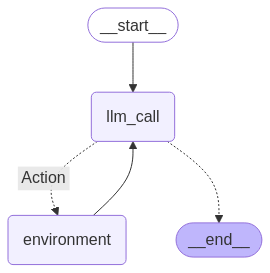

Error: [Errno 101] Network is unreachable
================================ Human Message =================================

Validate user 123 with these addresses:
                            - 123 Fake st in Boston, MA
                            - 234 Pretend Boulevard in Houston, TX
                            
                            Then send an email to nattapat.7140@gmail.com with:
                            Subject: User Validation Result
                            Body: Hi Best, hope you're doing well. Just checking in!
                            Sender: nattapat.0645@gmail.com
                            Password: a0645402317 
                         
================================== Ai Message ==================================
Tool Calls:
  validate_user (35e711e5-1b31-4d03-ae35-09ce01f917a9)
 Call ID: 35e711e5-1b31-4d03-ae35-09ce01f917a9
  Args:
    addresses: ['123 Fake st in Boston, MA', '234 Pretend Boulevard in Houston, TX']
    user_id: 123
=================

In [3]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from typing_extensions import Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant. You can call tools to perform tasks such as: Validating users (user ID and addresses), Sending emails via Gmail (with subject/body/from email/password) and Math operations like add, multiply, divide."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
        
    # print("tool_node", result)
    return {"messages": result}

  

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
# messages = [HumanMessage(content="Could you validate user 123? Thet previously lived at 123 Fake st in boston MA and 234 Pretend Boulevard in Houston TX. Then Send an email to nattapat.7140@gmail.com saying 'Hi Best, hope you're doing well. Just checking in!' with subject from user validation result. Use sender email nattapat.0645@gmail.com and app password a0645402317. ")]
messages = [HumanMessage(content=
                         """Validate user 123 with these addresses:
                            - 123 Fake st in Boston, MA
                            - 234 Pretend Boulevard in Houston, TX
                            
                            Then send an email to nattapat.7140@gmail.com with:
                            Subject: User Validation Result
                            Body: Hi Best, hope you're doing well. Just checking in!
                            Sender: nattapat.0645@gmail.com
                            Password: a0645402317 
                         """)]


messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

## Run another agent

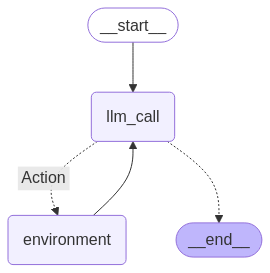

Error: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d2e1a72fcca58-73dbfa595e4sm4856406b3a.88 - gsmtp')
================================ Human Message =================================

multiply 4 with 5 
                            Then add 6
                            Then divide by 2
                            Then Keep result 
                            And send an email to nattapat.7140@gmail.com with:
                            Subject: User Validation Result
                            Body: Hi Best, hope you're doing well. {result}
                            Sender: nattapat.0645@gmail.com
                            Password: a0645402317 
                         
================================== Ai Message ==================================
Tool Calls:
  multiply (c645b212-566b-47fd-8bf3-6b7e715d0197)
 Call ID: c645b212-566b-47fd-8bf3-6b7e715d0197
  Args:
    a: 4
    b: 5
=======

In [4]:
# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
# messages = [HumanMessage(content="Could you validate user 123? Thet previously lived at 123 Fake st in boston MA and 234 Pretend Boulevard in Houston TX. Then Send an email to nattapat.7140@gmail.com saying 'Hi Best, hope you're doing well. Just checking in!' with subject from user validation result. Use sender email nattapat.0645@gmail.com and app password a0645402317. ")]
messages = [HumanMessage(content=
                         """multiply 4 with 5 
                            Then add 6
                            Then divide by 2
                            Then Keep result 
                            And send an email to nattapat.7140@gmail.com with:
                            Subject: User Validation Result
                            Body: Hi Best, hope you're doing well. {result}
                            Sender: nattapat.0645@gmail.com
                            Password: a0645402317 
                         """)]


messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()